In [ ]:
!pip install kaggle

In [ ]:
import os
from zipfile import ZipFile
import json
import shutil

In [ ]:
kaggle_credentails = json.load(open("kaggle.json"))

In [ ]:
os.environ['Kaggle_Username'] = kaggle_credentails['username']
os.environ['Kaggle_Key'] = kaggle_credentails['key']

In [ ]:
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 98% 158M/161M [00:08<00:00, 24.3MB/s]
100% 161M/161M [00:08<00:00, 20.9MB/s]


In [ ]:
!ls

corn-or-maize-leaf-disease-dataset.zip	kaggle.json  sample_data


Unzipping the dataset

In [ ]:
with ZipFile("corn-or-maize-leaf-disease-dataset.zip",'r') as zip_ref:
  zip_ref.extractall()

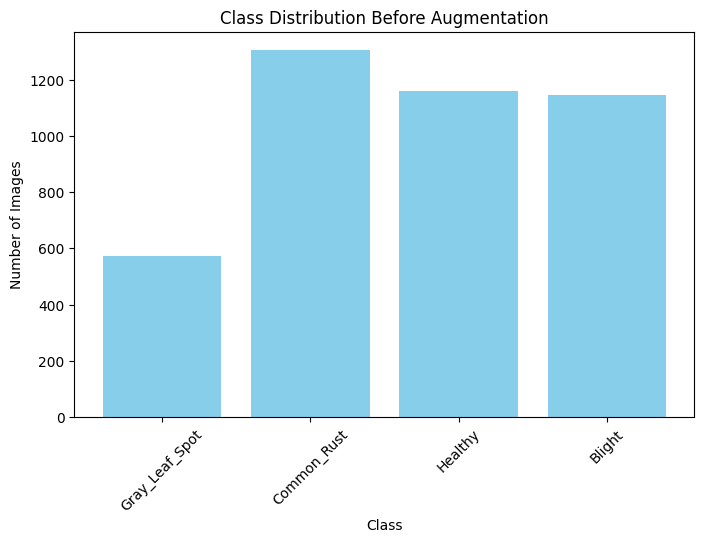

Class Distribution: {'Gray_Leaf_Spot': 574, 'Common_Rust': 1306, 'Healthy': 1162, 'Blight': 1146}


In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
from collections import Counter

# Define dataset path
dataset_path = "/content/data"

# Count samples per class
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_counts[class_name] = len(os.listdir(os.path.join(dataset_path, class_name)))

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution Before Augmentation")
plt.xticks(rotation=45)
plt.show()

print("Class Distribution:", class_counts)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0, DenseNet121, MobileNetV2, InceptionV3, Xception
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to create a model with transfer learning and fine-tuning
def create_transfer_learning_model(base_model, num_classes):
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def get_lr_scheduler():
    return tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [ ]:
input_shape = (224, 224, 3)
num_classes = 4

In [ ]:
models = {
    'VGG16': create_transfer_learning_model(VGG16(weights='imagenet', include_top=False, input_shape=input_shape), num_classes),
    'DenseNet121': create_transfer_learning_model(DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape), num_classes),
    'MobileNetV2': create_transfer_learning_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape), num_classes),
    'InceptionV3': create_transfer_learning_model(InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape), num_classes),
    'Xception': create_transfer_learning_model(Xception(weights='imagenet', include_top=False, input_shape=input_shape), num_classes)
}

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Custom CNN Model with batch normalization
def create_custom_cnn(num_classes):
    model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

custom_cnn_model = create_custom_cnn(num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory('/content/data', target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory('/content/data', target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation')

Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


In [ ]:
# Training and Validation
def train_model(model, train_generator, val_generator, epochs=20):
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[get_lr_scheduler()])
    val_acc = max(history.history['val_accuracy'])
    print(f'Best Validation Accuracy: {val_acc:.4f}')
    return history

In [ ]:
# Train each model
histories = {}
for name, model in models.items():
    print(f'Training {name}...')
    histories[name] = train_model(model, train_generator, val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training VGG16...
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - accuracy: 0.5850 - loss: 1.1231 - val_accuracy: 0.5179 - val_loss: 1.0688 - learning_rate: 1.0000e-04
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 200ms/step - accuracy: 0.8160 - loss: 0.5308 - val_accuracy: 0.6722 - val_loss: 0.8345 - learning_rate: 1.0000e-04
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy: 0.8362 - loss: 0.4486 - val_accuracy: 0.8624 - val_loss: 0.5052 - learning_rate: 1.0000e-04
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.8564 - loss: 0.4131 - val_accuracy: 0.8959 - val_loss: 0.3123 - learning_rate: 1.0000e-04
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.8714 - loss: 0.3560 - val_accuracy: 0.9127 - val_loss: 0.2518 - learning_rate: 1.0000e-04
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.8757 - loss: 0.3388 - val_accuracy: 0.9294 - val_loss: 0.2124 - learning_rate: 1.0000e-04
Epoch 7/20
105/105 ━━━━━━━━━

In [ ]:
print('Training Custom CNN...')
histories['Custom_CNN'] = train_model(custom_cnn_model, train_generator, val_generator)

Training Custom CNN...
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - accuracy: 0.7492 - loss: 0.7801 - val_accuracy: 0.3553 - val_loss: 3.1189 - learning_rate: 1.0000e-04
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8252 - loss: 0.4868 - val_accuracy: 0.5024 - val_loss: 3.0002 - learning_rate: 1.0000e-04
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.8502 - loss: 0.3852 - val_accuracy: 0.5646 - val_loss: 1.1991 - learning_rate: 1.0000e-04
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.8672 - loss: 0.3617 - val_accuracy: 0.8086 - val_loss: 0.5723 - learning_rate: 1.0000e-04
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.8821 - loss: 0.3383 - val_accuracy: 0.8780 - val_loss: 0.3115 - learning_rate: 1.0000e-04
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.8834 - loss: 0.3135 - val_accuracy: 0.8900 - val_loss: 0.2920 - learning_rate: 1.0000e-04
Epoch 7/20
105/105 ━━━━